# **Problem Statement & Objective**

The goal for this dataset is to forecast the spatio-temporal traffic volume based on the historical traffic volume and other features in neighboring locations. Specifically, the traffic volume is measured every 15 minutes at 36 sensor locations along two major highways in Northern Virginia/Washington D.C. capital region. The 47 features include: 1) the historical sequence of traffic volume sensed during the 10 most recent sample points (10 features), 2) week day (7 features), 3) hour of day (24 features), 4) road direction (4 features), 5) number of lanes (1 feature), and 6) name of the road (1 feature). The goal is to predict the traffic volume 15 minutes into the future for all sensor locations. With a given road network, we know the spatial connectivity between sensor locations.


# ***Importing required packages***

In [1]:
import scipy.io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# ***Importing dataset***

In [2]:
mat = scipy.io.loadmat('traffic_dataset.mat')

# **Reading and storing numpy array to python list**

In [3]:
tra_X_tr_list=[mat['tra_X_tr'][0][i].toarray() for  i in range(len(mat['tra_X_tr'][0]))]
tra_X_te_list=[mat['tra_X_te'][0][i].toarray() for  i in range(len(mat['tra_X_te'][0]))]
tra_Y_tr_list=[mat['tra_Y_tr'][i] for  i in range(len(mat['tra_Y_tr']))]
tra_Y_te_list=[mat['tra_Y_te'][i] for  i in range(len(mat['tra_Y_te']))]
tra_adj_mat_list=[mat['tra_adj_mat'][i] for  i in range(len(mat['tra_adj_mat']))]

***Creating a dictionary for calculating number of connection for a soatial location***

In [4]:
dict={}
for i in range(len(tra_adj_mat_list)):
    dict[i+1]=list(tra_adj_mat_list[i]).count(1)

def dict_apply(text):
    return dict[text]

***Creating train data frame and target(next_traffic_flow) for each record  by getting the traffic flow for next 15 minute***

In [5]:
out_train=list(zip([(i+1,j+1,tra_X_tr_list[i][j],tra_Y_tr_list[j][i]) for i in range(len(tra_Y_tr_list[0])) 
              for j in range(len(tra_Y_tr_list))]))
df_train=pd.DataFrame([x[0] for x in out_train],columns=['quarter-hours', 'spatial_location_number','input_array','traffic_flow'])
df_train['next_traffic_flow'] = df_train.groupby("spatial_location_number")['traffic_flow'].shift(-1)
df_train['no_of_connection']=df_train['spatial_location_number'].apply(dict_apply)
df_train[[f'Feature {i}' for i in range(0, 48)]]=pd.DataFrame(df_train["input_array"].tolist(), index= df_train.index)
df_train = df_train.drop(['input_array','quarter-hours'], axis=1)
df_train = df_train.dropna()

***Creating test data frame and target(next_traffic_flow) for each record  by getting the traffic flow for next 15 minute***

***Created a dataframe called df_test_future which having the information of last quarter for predicting the traffic flow for next 15 minutes.***


In [6]:
out_test=list(zip([(i+1,j+1,tra_X_te_list[i][j],tra_Y_te_list[j][i]) for i in range(len(tra_Y_te_list[0])) 
              for j in range(len(tra_Y_te_list))]))
df_test=pd.DataFrame([x[0] for x in out_test],columns=['quarter-hours', 'spatial_location_number','input_array','traffic_flow'])
df_test['next_traffic_flow'] = df_test.groupby("spatial_location_number")['traffic_flow'].shift(-1)
df_test['no_of_connection']=df_test['spatial_location_number'].apply(dict_apply)
df_test[[f'Feature {i}' for i in range(0, 48)]]=pd.DataFrame(df_test["input_array"].tolist(), index= df_test.index)
df_test_future=df_test[df_test['quarter-hours']==840]
df_test = df_test.drop(['input_array','quarter-hours'], axis=1)
#df_test_future = df_test_future.drop(['input_array','quarter-hours'], axis=1)
df_test = df_test.dropna()

***Basic Statistics***

In [7]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
spatial_location_number,45360.0,18.500000,10.388409,1.0,9.750000,18.500000,27.250000,36.0
traffic_flow,45360.0,0.304206,0.199539,0.0,0.126576,0.293321,0.442784,1.0
next_traffic_flow,45360.0,0.304464,0.199538,0.0,0.127043,0.293788,0.442901,1.0
no_of_connection,45360.0,2.388889,1.318216,1.0,2.000000,2.000000,2.000000,7.0
Feature 0,45360.0,0.303488,0.199528,0.0,0.125642,0.292387,0.442317,1.0
Feature 1,45360.0,0.303432,0.199580,0.0,0.125175,0.292387,0.442317,1.0
Feature 2,45360.0,0.303383,0.199627,0.0,0.125175,0.292387,0.442317,1.0
Feature 3,45360.0,0.303356,0.199653,0.0,0.124708,0.292387,0.442317,1.0
Feature 4,45360.0,0.303347,0.199664,0.0,0.124708,0.292387,0.442317,1.0
Feature 5,45360.0,0.303359,0.199658,0.0,0.124708,0.292387,0.442317,1.0


In [8]:
print ("Rows     : " , df_train.shape[0])
print ("Columns  : " , df_train.shape[1])
print ("\nFeatures : \n" , df_train.columns.tolist())
print ("\nMissing values :  ", df_train.isnull().sum().values.sum())
print ("\nUnique values :  \n",df_train.nunique())

Rows     :  45360
Columns  :  52

Features : 
 ['spatial_location_number', 'traffic_flow', 'next_traffic_flow', 'no_of_connection', 'Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7', 'Feature 8', 'Feature 9', 'Feature 10', 'Feature 11', 'Feature 12', 'Feature 13', 'Feature 14', 'Feature 15', 'Feature 16', 'Feature 17', 'Feature 18', 'Feature 19', 'Feature 20', 'Feature 21', 'Feature 22', 'Feature 23', 'Feature 24', 'Feature 25', 'Feature 26', 'Feature 27', 'Feature 28', 'Feature 29', 'Feature 30', 'Feature 31', 'Feature 32', 'Feature 33', 'Feature 34', 'Feature 35', 'Feature 36', 'Feature 37', 'Feature 38', 'Feature 39', 'Feature 40', 'Feature 41', 'Feature 42', 'Feature 43', 'Feature 44', 'Feature 45', 'Feature 46', 'Feature 47']

Missing values :   0

Unique values :  
 spatial_location_number      36
traffic_flow               1902
next_traffic_flow          1902
no_of_connection              6
Feature 0                  1901
Feat

In [9]:
numeric_features=[f'Feature {i}' for i in range(0, 10)]
categorical_features=[f'Feature {i}' for i in range(10, 48)]+['no_of_connection']

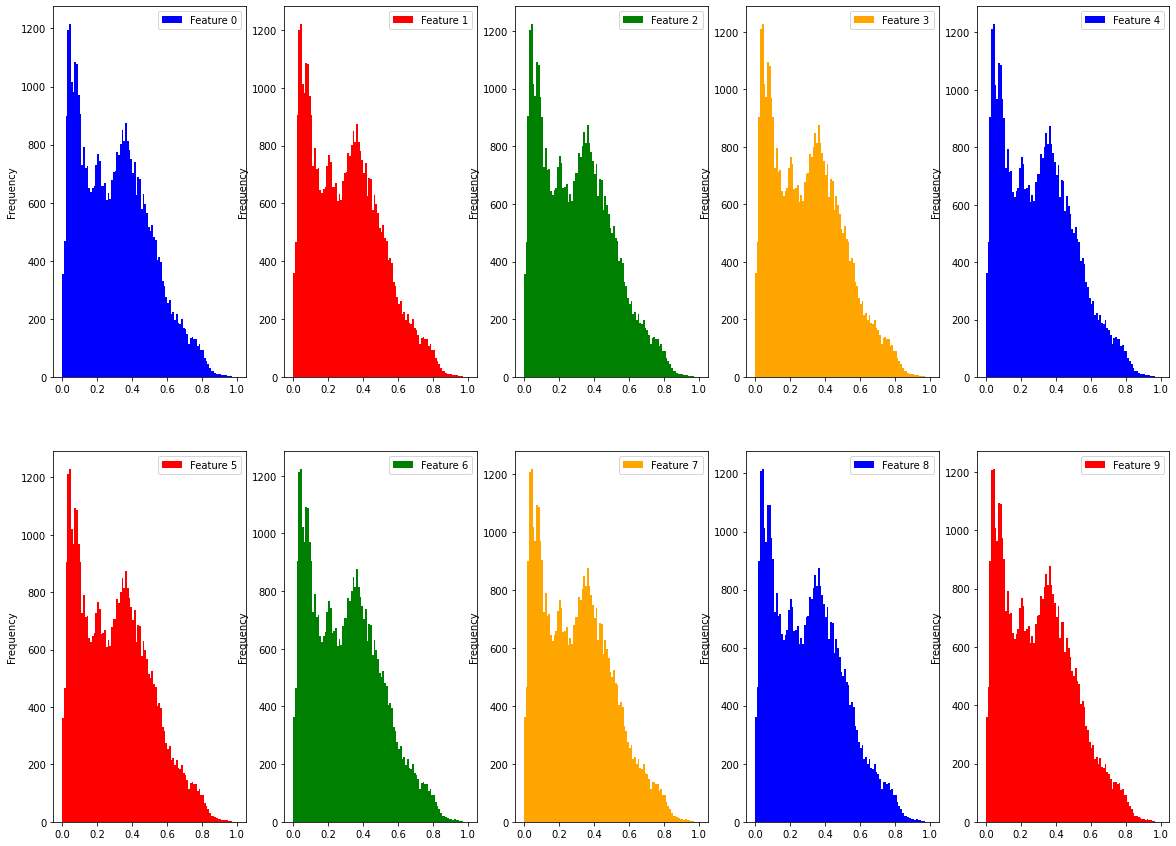

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
df_train.plot(kind="hist", y="Feature 0", bins=100, color="b", ax=axes[0][0])
df_train.plot(kind="hist", y="Feature 1", bins=100, color="r", ax=axes[0][1])
df_train.plot(kind="hist", y="Feature 2", bins=100, color="g", ax=axes[0][2])
df_train.plot(kind="hist", y="Feature 3", bins=100, color="orange", ax=axes[0][3])
df_train.plot(kind="hist", y="Feature 4", bins=100, color="b", ax=axes[0][4])

df_train.plot(kind="hist", y="Feature 5", bins=100, color="r", ax=axes[1][0])
df_train.plot(kind="hist", y="Feature 6", bins=100, color="g", ax=axes[1][1])
df_train.plot(kind="hist", y="Feature 7", bins=100, color="orange", ax=axes[1][2])
df_train.plot(kind="hist", y="Feature 8", bins=100, color="b", ax=axes[1][3])
df_train.plot(kind="hist", y="Feature 9", bins=100, color="r", ax=axes[1][4])

plt.show()

***We have plotted Feature 0 and Next Traffic Flow and observed a primarily linear relationship***

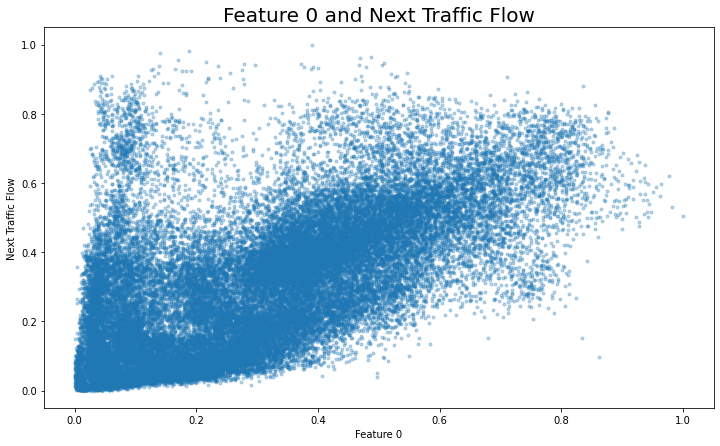

In [11]:
plt.figure(figsize=(12,7))
plt.xlabel('Feature 0')
plt.ylabel('Next Traffic Flow')
plt.title('Feature 0 and Next Traffic Flow', fontsize=20)
plt.plot(df_train['Feature 0'], df_train.next_traffic_flow, ".",alpha = 0.3)

***Next Traffic Flow is proportional to the number of connections for a particular spatial location.***

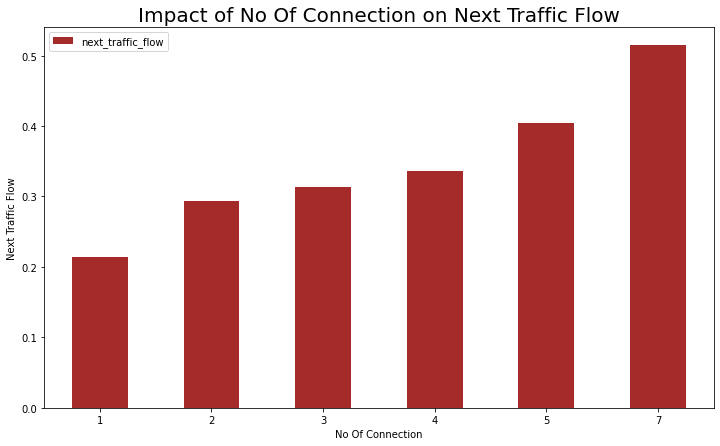

In [12]:
Item_Type_pivot = \
df_train.pivot_table(index='no_of_connection', values="next_traffic_flow", aggfunc=np.median)

Item_Type_pivot.plot(kind='bar',color='brown',figsize=(12,7))
plt.xlabel('No Of Connection')
plt.ylabel("Next Traffic Flow")
plt.title("Impact of No Of Connection on Next Traffic Flow", fontsize=20)
plt.xticks(rotation=0)
plt.show()

***Feature 10 vs Next Traffic Flow***

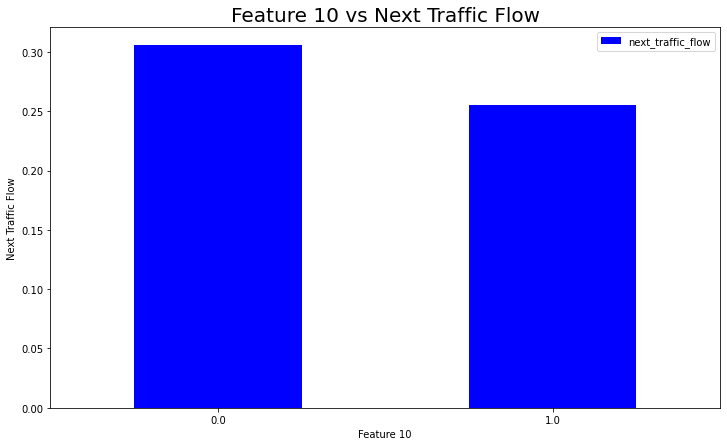

In [13]:
Item_Type_pivot = \
df_train.pivot_table(index='Feature 10', values="next_traffic_flow", aggfunc=np.median)

Item_Type_pivot.plot(kind='bar',color='blue',figsize=(12,7))
plt.xlabel('Feature 10')
plt.ylabel("Next Traffic Flow")
plt.title("Feature 10 vs Next Traffic Flow",fontsize=20)
plt.xticks(rotation=0)
plt.show()

***Correlation analysis on numeric features***

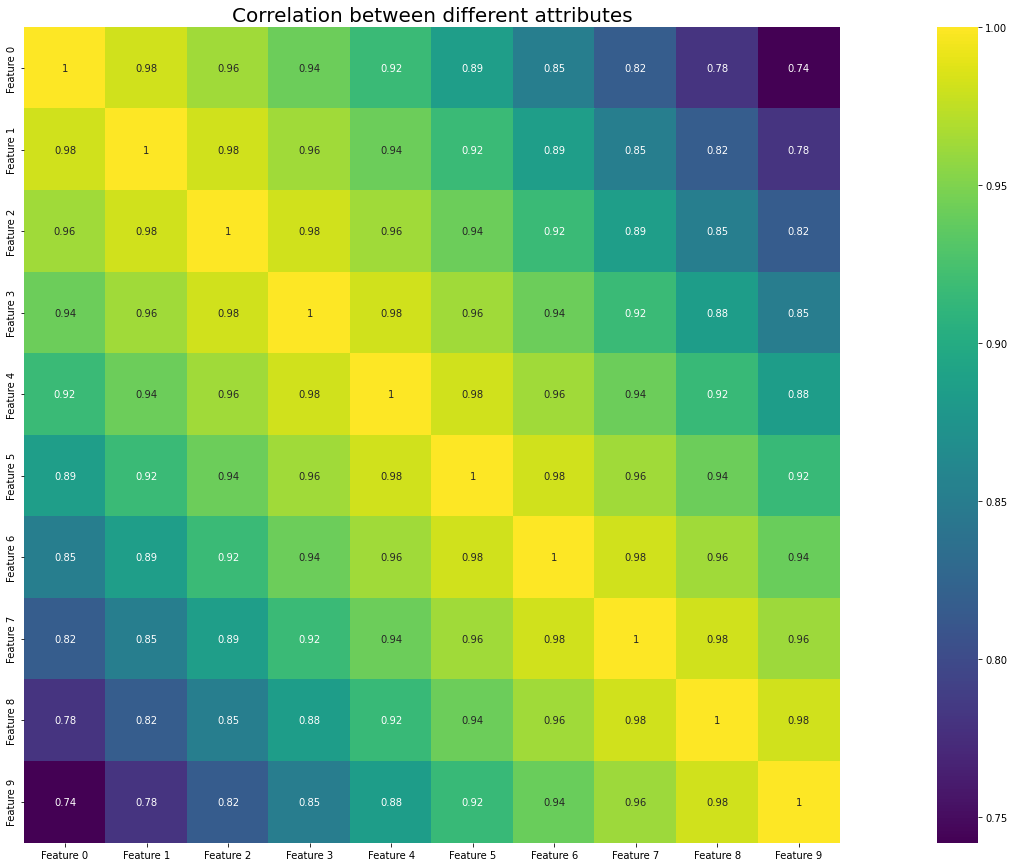

In [14]:
plt.figure(figsize=(35,15))
sns.heatmap(df_train[numeric_features].corr(),vmax=1, square=True,annot=True, cmap='viridis')
plt.title('Correlation between different attributes', fontsize=20)
plt.show()

***Take a threshold of 0.80 and only selected Feature 0 and Feature 8***

In [15]:
def filter(df, threshold):
    col = [] # Set of all the names of deleted columns
    #corr_matrix = dataset.corr()
    for i in range(len(df.columns)):
        for j in range(i):
            if (df.iloc[i, j] > threshold) and (df.columns[j] not in col):
                colname = df.columns[i] # getting the name of column
                col.append(colname)
                # print(colname)
                # if colname in dataset.columns:
                #     del dataset[colname] # deleting the column from the dataset
    return list(set(col))
num_features=list(set(numeric_features)-set(filter(df_train[numeric_features].corr(), 0.80)))

In [16]:
num_features=['Feature 8', 'Feature 0']+['traffic_flow']
categorical_features.remove('Feature 39')

In [17]:
final_features=num_features+categorical_features

***Seperating independent variabsles and target***

In [18]:
data=df_train.copy()
X = data.drop(['spatial_location_number','next_traffic_flow'], axis=1)
X=X[final_features]
y = data.next_traffic_flow.to_numpy()

**Ridge regression pipeline for baseline model and Hyperparameter tunning**

In [19]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Ridge())
])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [20]:
result=search.fit(X,y)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .................model__alpha=0.1;, score=-0.001 total time=   0.1s
[CV 2/5] END .................model__alpha=0.1;, score=-0.001 total time=   0.1s
[CV 3/5] END .................model__alpha=0.1;, score=-0.002 total time=   0.1s
[CV 4/5] END .................model__alpha=0.1;, score=-0.002 total time=   0.1s
[CV 5/5] END .................model__alpha=0.1;, score=-0.001 total time=   0.1s
[CV 1/5] END .................model__alpha=0.2;, score=-0.001 total time=   0.1s
[CV 2/5] END .................model__alpha=0.2;, score=-0.001 total time=   0.1s
[CV 3/5] END .................model__alpha=0.2;, score=-0.002 total time=   0.1s
[CV 4/5] END .................model__alpha=0.2;, score=-0.002 total time=   0.1s
[CV 5/5] END .................model__alpha=0.2;, score=-0.001 total time=   0.1s
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-0.001 total time=   0.0s
[CV 2/5] END .model__alpha=0.30000000000000004;

**Selected the top 10 most important features and finally created the  final model using only 10 Features.**

In [21]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.0013181924275077212
Best Hyperparameters: {'model__alpha': 0.1}


In [22]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Ridge(alpha=0.1))
])

In [23]:
pipeline.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()), ('model', Ridge(alpha=0.1))])

In [24]:
dic_feature_imp={}
for i,v in enumerate(pipeline[1].coef_):
    dic_feature_imp[final_features[i]]=v
    i=i+1

In [25]:
top_feature_count=10
imp_features=sorted(dic_feature_imp, key=lambda dict_key: abs(dic_feature_imp[dict_key]), reverse=True)[:top_feature_count]
imp_features

['traffic_flow',
 'Feature 8',
 'Feature 17',
 'Feature 16',
 'Feature 36',
 'Feature 35',
 'Feature 26',
 'Feature 34',
 'Feature 31',
 'Feature 37']

***Final Model***

In [26]:
pipeline.fit(X[imp_features],y)

Pipeline(steps=[('scaler', StandardScaler()), ('model', Ridge(alpha=0.1))])

In [27]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

**Prediction on test data**

In [28]:
data=df_test.copy()
X = data.drop(['spatial_location_number','next_traffic_flow'], axis=1)
X=X[imp_features]
y = data.next_traffic_flow.to_numpy()
p=np.asarray([x if x > 0 else 0 for x in list(pipeline.predict(X))])
print("Symmetric mean absolute percentage error -> {}".format(round(smape(y, p),2)))
#print("Mean Squared Error -> {}".format(round(mean_squared_error(y, p),4)))
print("Root Mean Squared Error -> {}".format(round(mean_squared_error(y, p),4)))
print("Mean Absolute Error -> {}".format(round(mean_absolute_error(y, p),4)))
print("r2_score -> {}".format(round(r2_score(y, p),4)))
print("Adjusted r2_score -> {}".format(round(1 - ( 1-pipeline.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 ),4)))

Symmetric mean absolute percentage error -> 11.22
Root Mean Squared Error -> 0.0013
Mean Absolute Error -> 0.0252
r2_score -> 0.9678
Adjusted r2_score -> 0.9678


*Distribution of residuals*

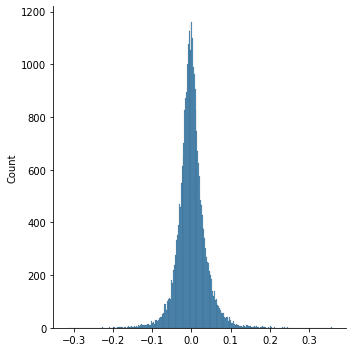

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.displot(y-p)

**Prediction for each spatial location**

For sensor location number -> 1 
Symmetric mean absolute percentage error -> 10.06
Mean absolute percentage error -> 10.14
Root Mean Squared Error -> 0.0007
Mean Absolute Error -> 0.0193
r2_score -> 0.9534
Adjusted r2_score -> 0.9528


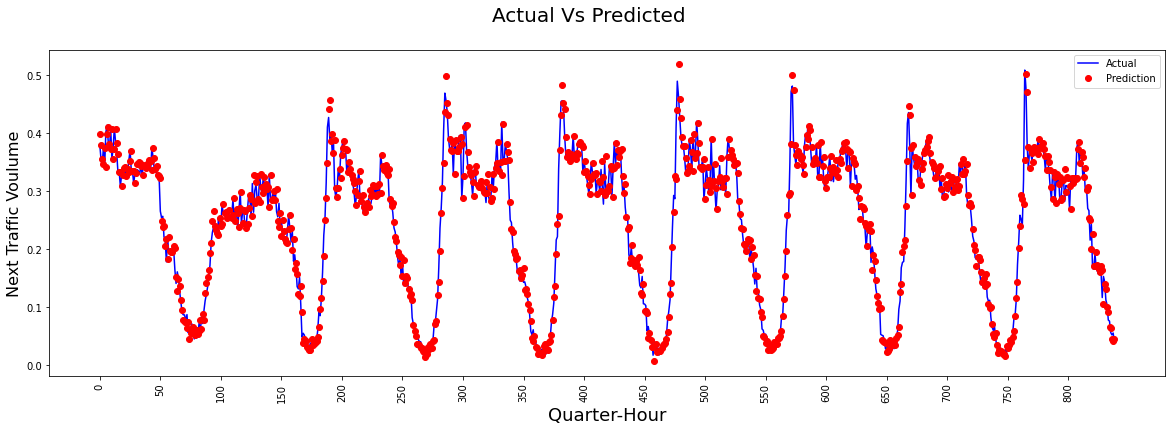

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 2 
Symmetric mean absolute percentage error -> 8.4
Mean absolute percentage error -> 8.59
Root Mean Squared Error -> 0.0014
Mean Absolute Error -> 0.0258
r2_score -> 0.9703
Adjusted r2_score -> 0.9699


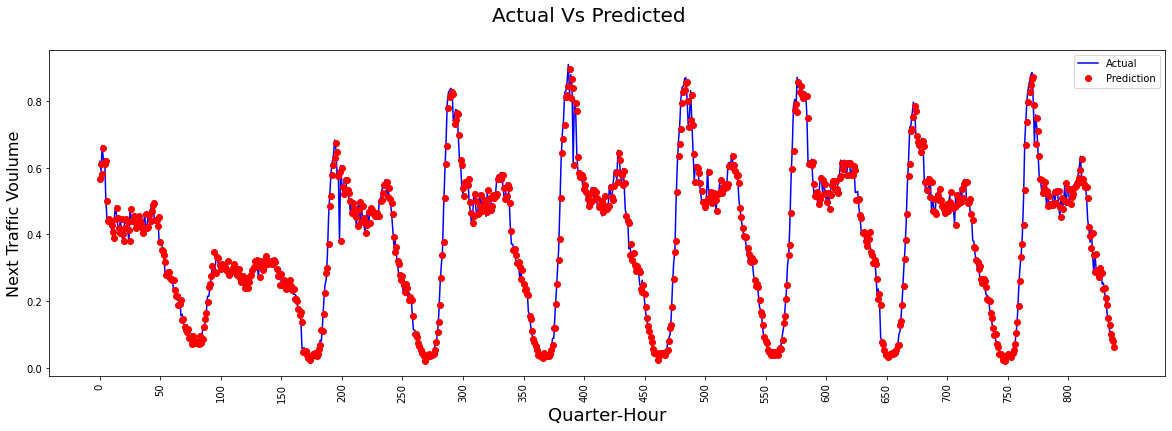

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 3 
Symmetric mean absolute percentage error -> 10.83
Mean absolute percentage error -> 11.52
Root Mean Squared Error -> 0.0007
Mean Absolute Error -> 0.0198
r2_score -> 0.9356
Adjusted r2_score -> 0.9348


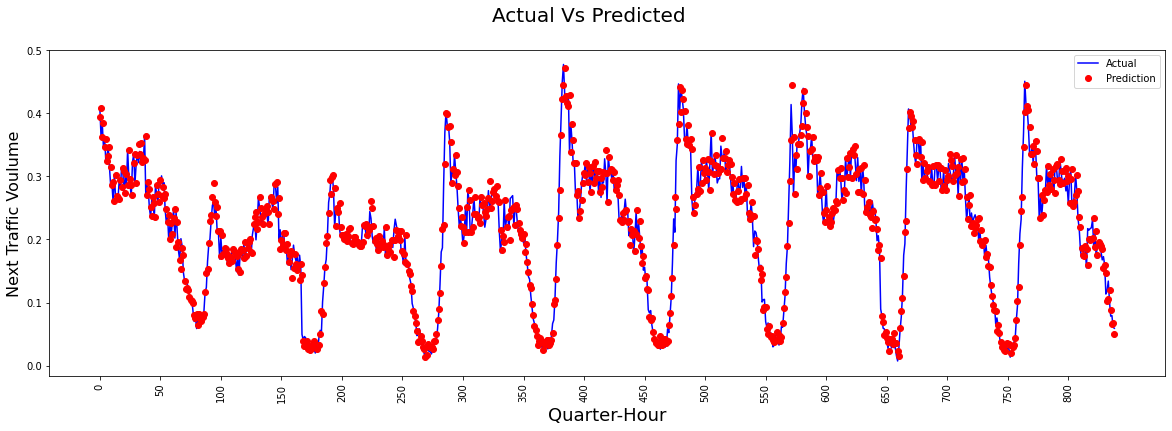

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 4 
Symmetric mean absolute percentage error -> 8.55
Mean absolute percentage error -> 8.97
Root Mean Squared Error -> 0.0007
Mean Absolute Error -> 0.0192
r2_score -> 0.9562
Adjusted r2_score -> 0.9557


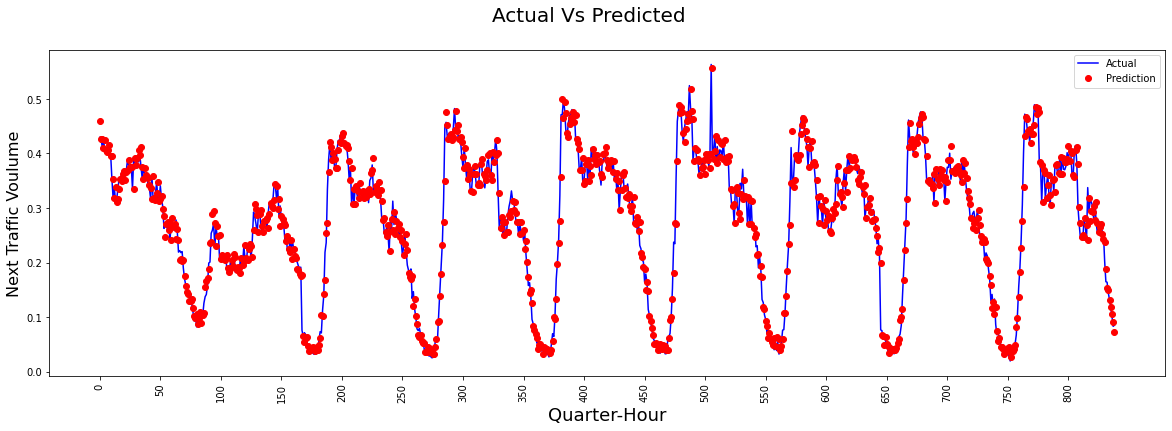

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 5 
Symmetric mean absolute percentage error -> 8.59
Mean absolute percentage error -> 8.98
Root Mean Squared Error -> 0.0013
Mean Absolute Error -> 0.0268
r2_score -> 0.971
Adjusted r2_score -> 0.9707


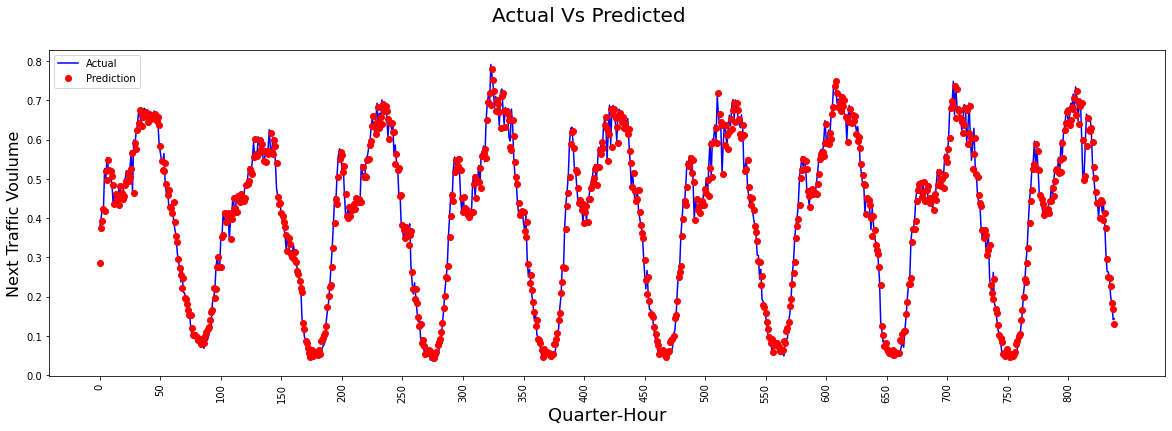

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 6 
Symmetric mean absolute percentage error -> 9.85
Mean absolute percentage error -> 10.65
Root Mean Squared Error -> 0.0009
Mean Absolute Error -> 0.0232
r2_score -> 0.9661
Adjusted r2_score -> 0.9657


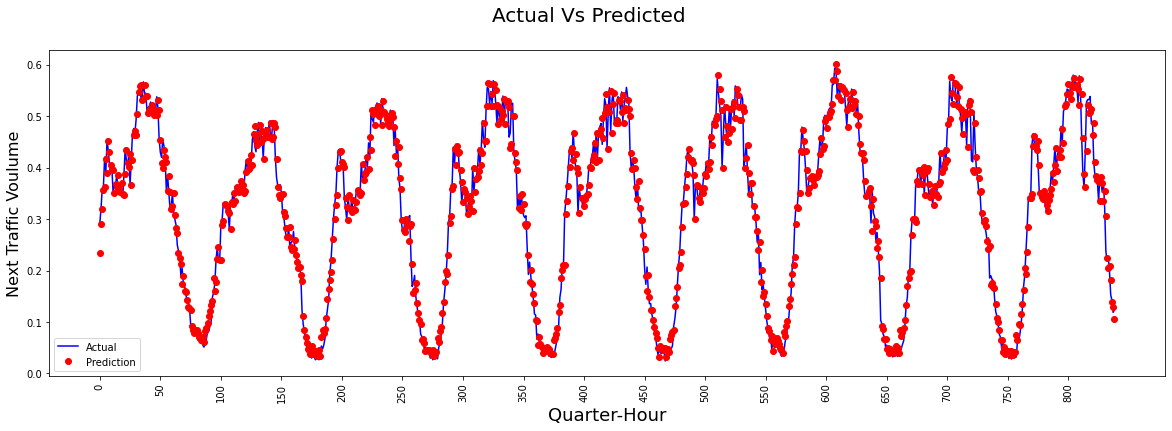

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 7 
Symmetric mean absolute percentage error -> 8.85
Mean absolute percentage error -> 9.43
Root Mean Squared Error -> 0.0013
Mean Absolute Error -> 0.0254
r2_score -> 0.9646
Adjusted r2_score -> 0.9642


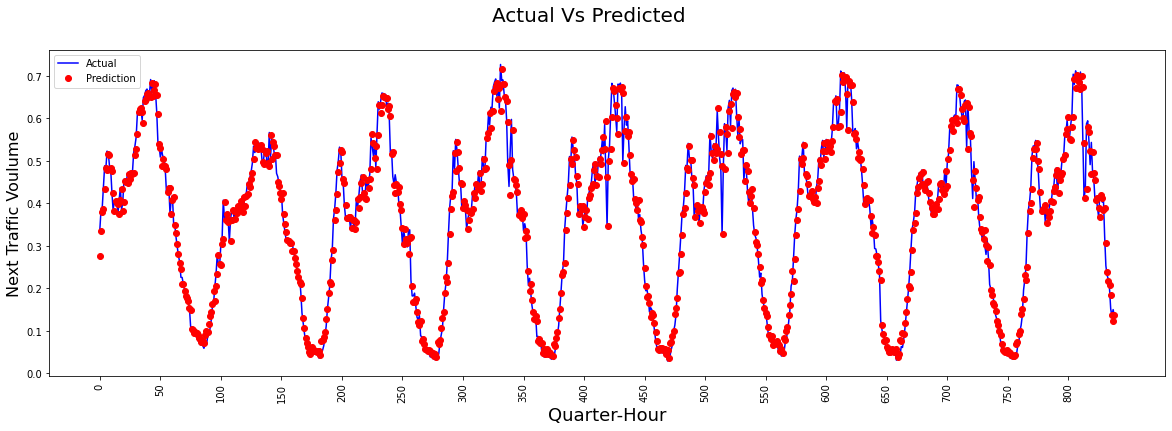

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 8 
Symmetric mean absolute percentage error -> 9.4
Mean absolute percentage error -> 10.07
Root Mean Squared Error -> 0.0007
Mean Absolute Error -> 0.0196
r2_score -> 0.9607
Adjusted r2_score -> 0.9602


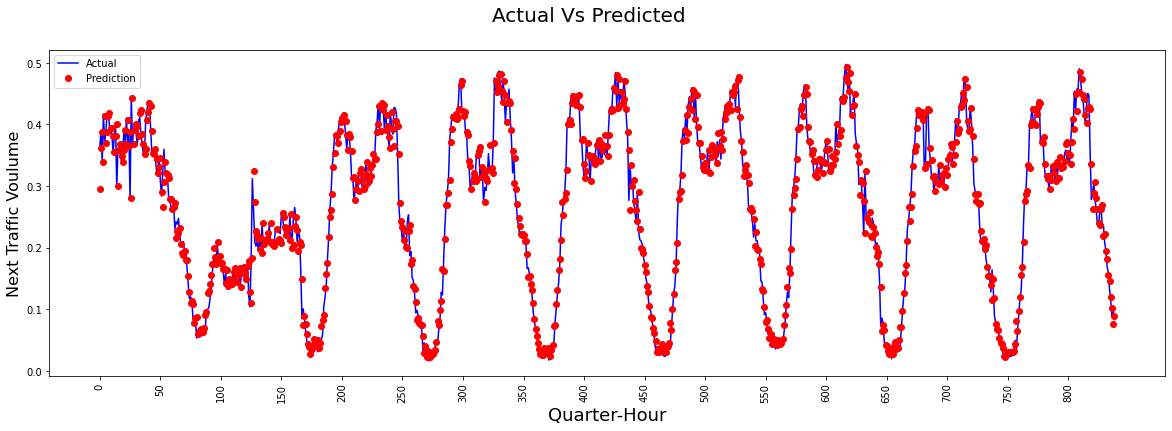

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 9 
Symmetric mean absolute percentage error -> 8.32
Mean absolute percentage error -> 8.25
Root Mean Squared Error -> 0.0016
Mean Absolute Error -> 0.0296
r2_score -> 0.9584
Adjusted r2_score -> 0.9579


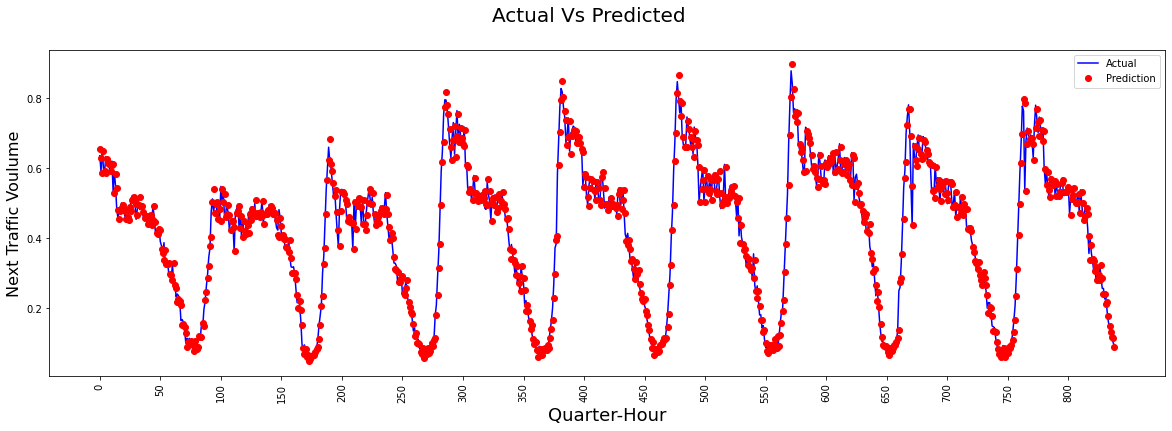

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 10 
Symmetric mean absolute percentage error -> 8.03
Mean absolute percentage error -> 7.97
Root Mean Squared Error -> 0.0018
Mean Absolute Error -> 0.0296
r2_score -> 0.9584
Adjusted r2_score -> 0.9579


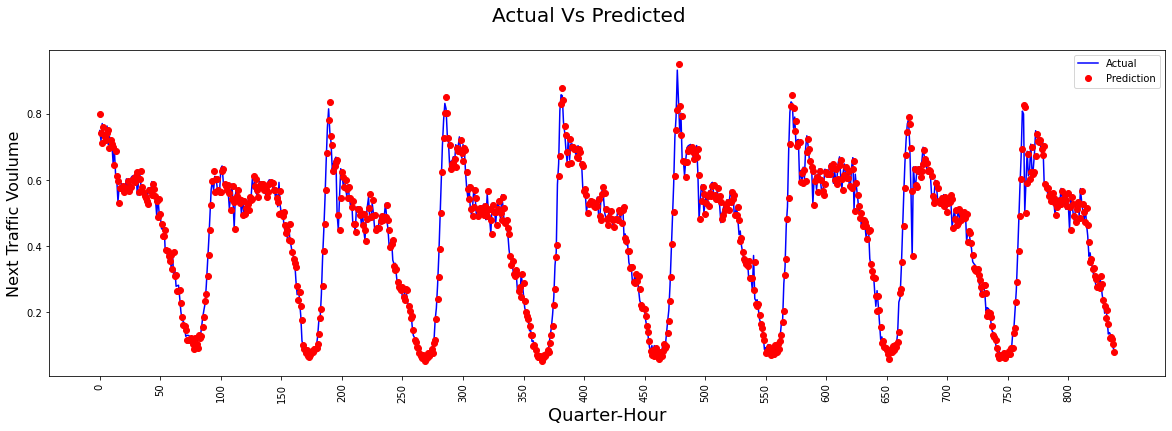

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 11 
Symmetric mean absolute percentage error -> 8.64
Mean absolute percentage error -> 8.57
Root Mean Squared Error -> 0.0018
Mean Absolute Error -> 0.0315
r2_score -> 0.9596
Adjusted r2_score -> 0.9591


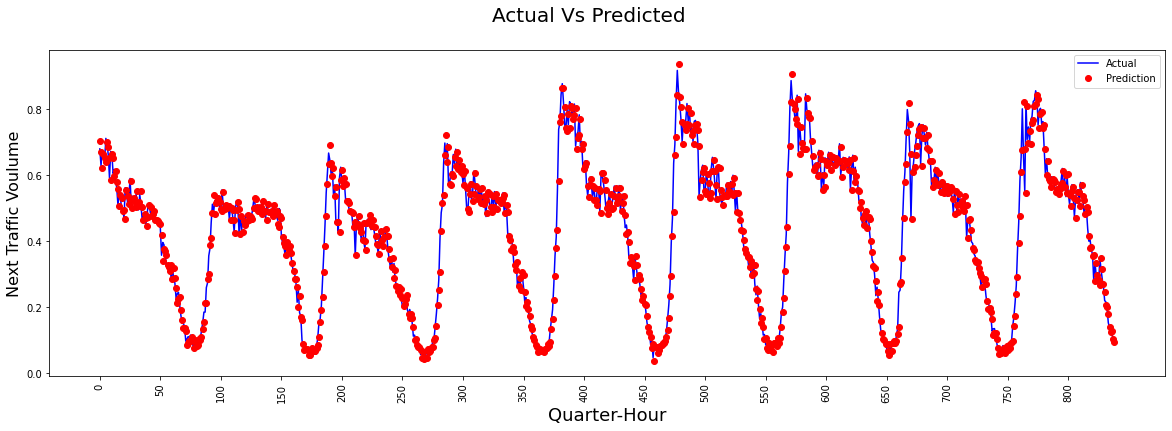

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 12 
Symmetric mean absolute percentage error -> 8.46
Mean absolute percentage error -> 8.51
Root Mean Squared Error -> 0.0011
Mean Absolute Error -> 0.0239
r2_score -> 0.955
Adjusted r2_score -> 0.9544


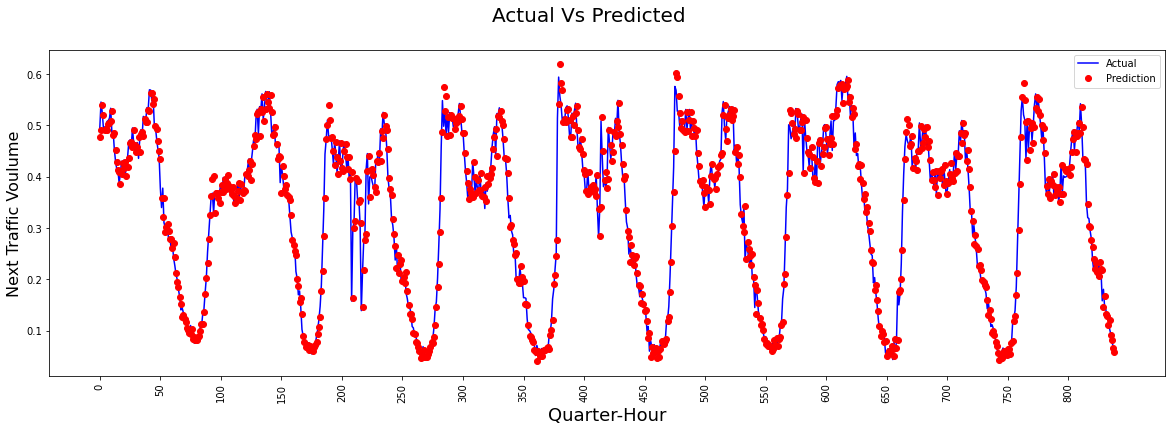

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 13 
Symmetric mean absolute percentage error -> 8.32
Mean absolute percentage error -> 8.26
Root Mean Squared Error -> 0.0016
Mean Absolute Error -> 0.0287
r2_score -> 0.9528
Adjusted r2_score -> 0.9522


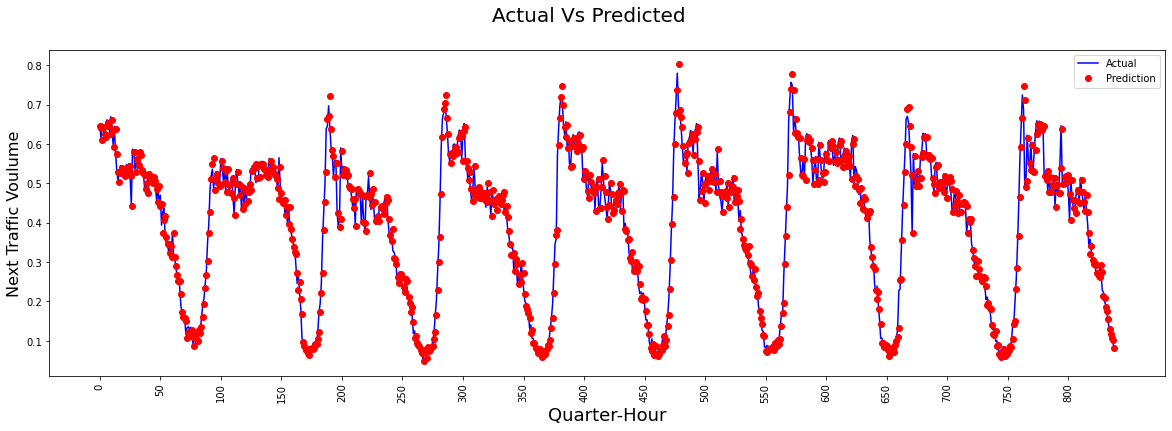

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 14 
Symmetric mean absolute percentage error -> 8.7
Mean absolute percentage error -> 8.67
Root Mean Squared Error -> 0.0021
Mean Absolute Error -> 0.0326
r2_score -> 0.9578
Adjusted r2_score -> 0.9573


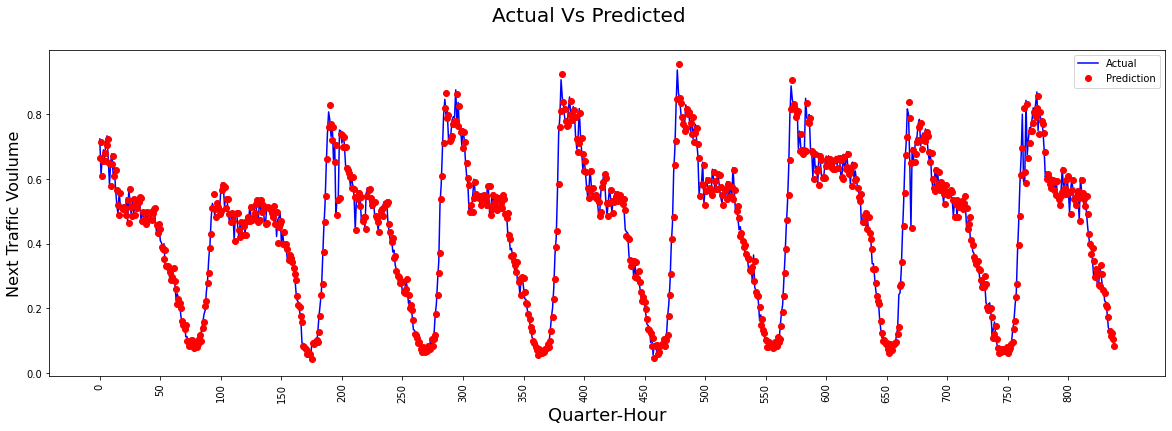

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 15 
Symmetric mean absolute percentage error -> 7.73
Mean absolute percentage error -> 7.73
Root Mean Squared Error -> 0.0018
Mean Absolute Error -> 0.0319
r2_score -> 0.9678
Adjusted r2_score -> 0.9674


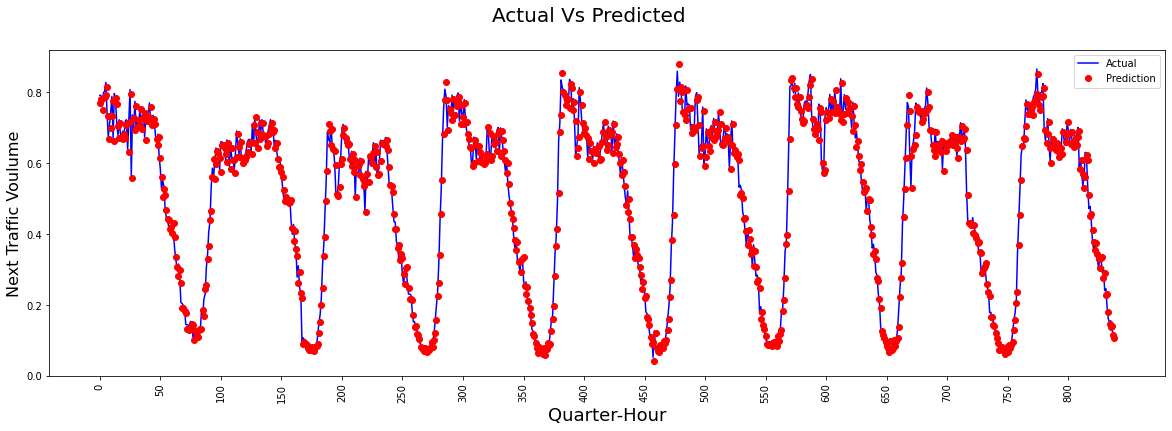

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 16 
Symmetric mean absolute percentage error -> 10.62
Mean absolute percentage error -> 11.31
Root Mean Squared Error -> 0.0004
Mean Absolute Error -> 0.0151
r2_score -> 0.9584
Adjusted r2_score -> 0.9579


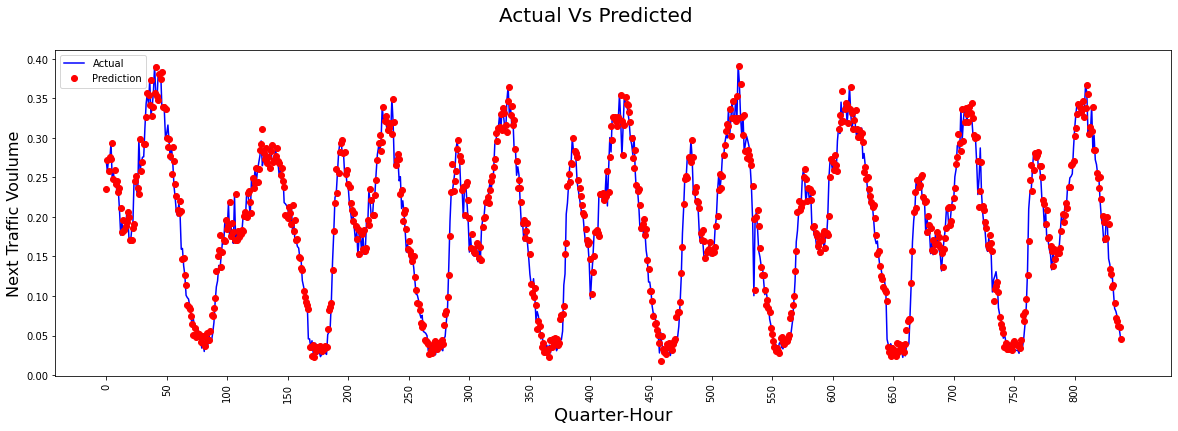

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 17 
Symmetric mean absolute percentage error -> 8.99
Mean absolute percentage error -> 9.36
Root Mean Squared Error -> 0.0011
Mean Absolute Error -> 0.0237
r2_score -> 0.9414
Adjusted r2_score -> 0.9407


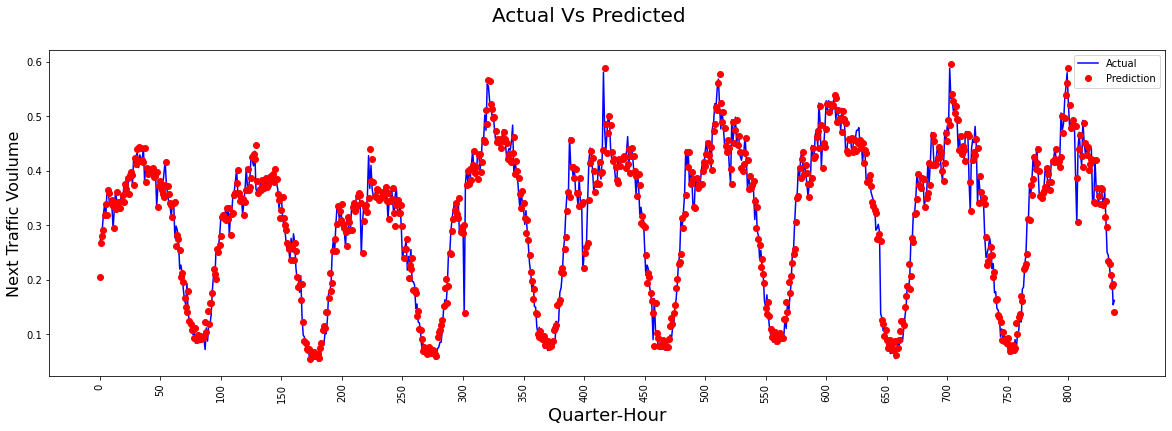

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 18 
Symmetric mean absolute percentage error -> 8.95
Mean absolute percentage error -> 9.19
Root Mean Squared Error -> 0.0014
Mean Absolute Error -> 0.0266
r2_score -> 0.9331
Adjusted r2_score -> 0.9323


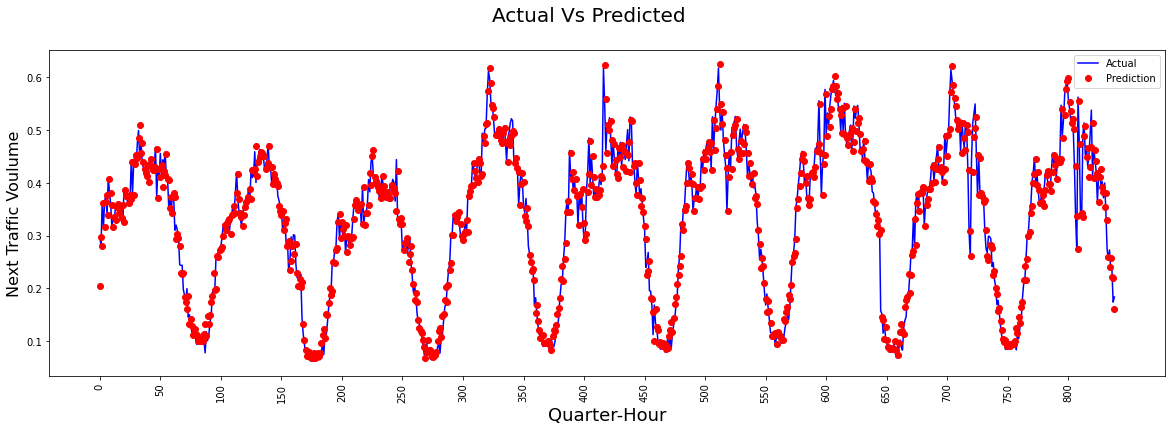

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 19 
Symmetric mean absolute percentage error -> 10.19
Mean absolute percentage error -> 10.54
Root Mean Squared Error -> 0.0015
Mean Absolute Error -> 0.0276
r2_score -> 0.9217
Adjusted r2_score -> 0.9208


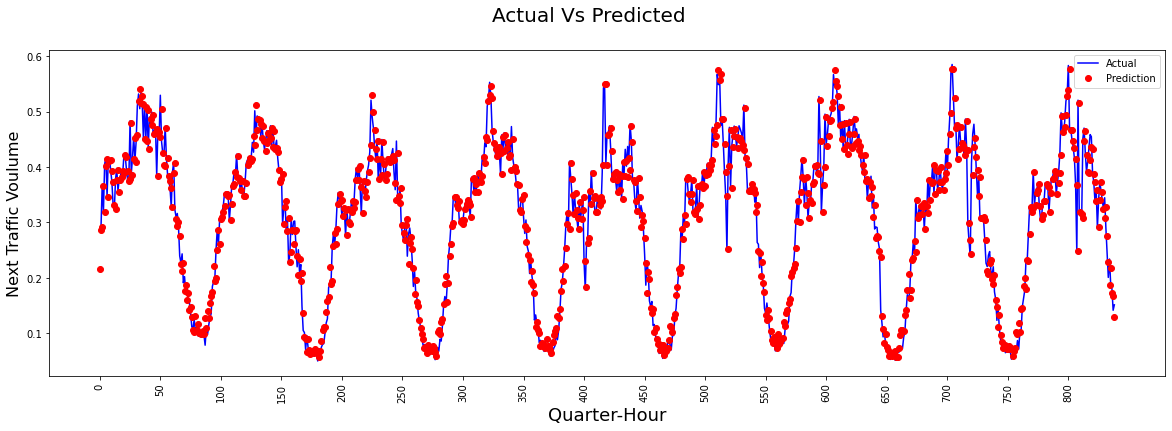

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 20 
Symmetric mean absolute percentage error -> 8.8
Mean absolute percentage error -> 9.0
Root Mean Squared Error -> 0.0022
Mean Absolute Error -> 0.0326
r2_score -> 0.9338
Adjusted r2_score -> 0.933


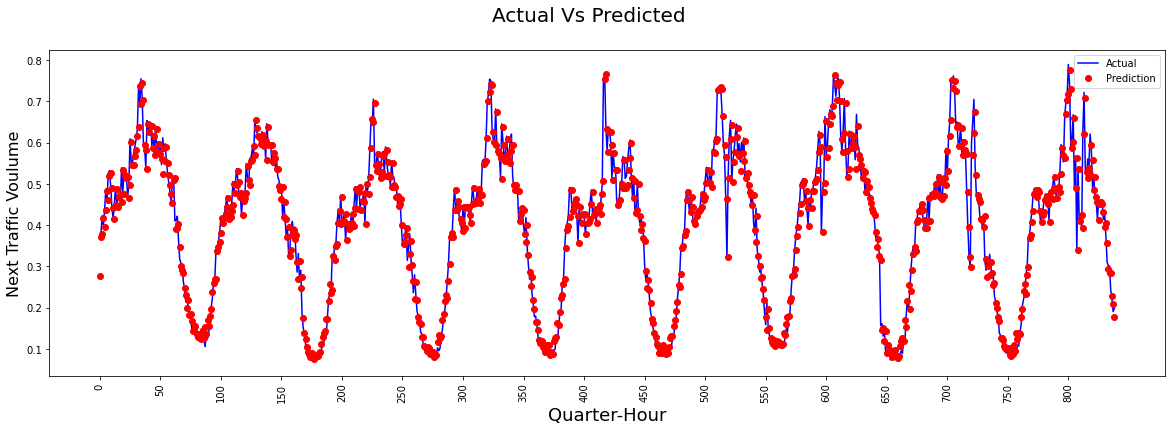

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 21 
Symmetric mean absolute percentage error -> 8.72
Mean absolute percentage error -> 8.94
Root Mean Squared Error -> 0.0018
Mean Absolute Error -> 0.0299
r2_score -> 0.9368
Adjusted r2_score -> 0.936


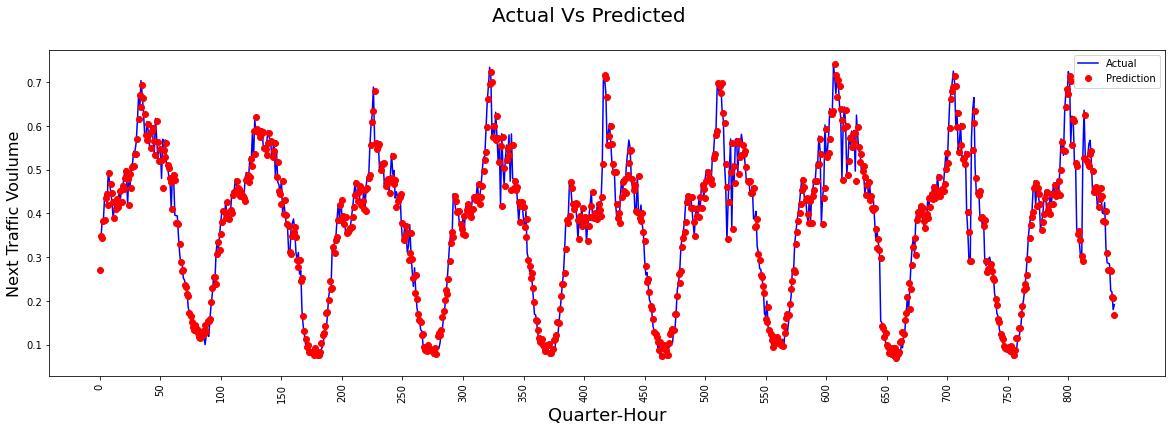

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 22 
Symmetric mean absolute percentage error -> 8.54
Mean absolute percentage error -> 8.69
Root Mean Squared Error -> 0.0021
Mean Absolute Error -> 0.0318
r2_score -> 0.9349
Adjusted r2_score -> 0.9341


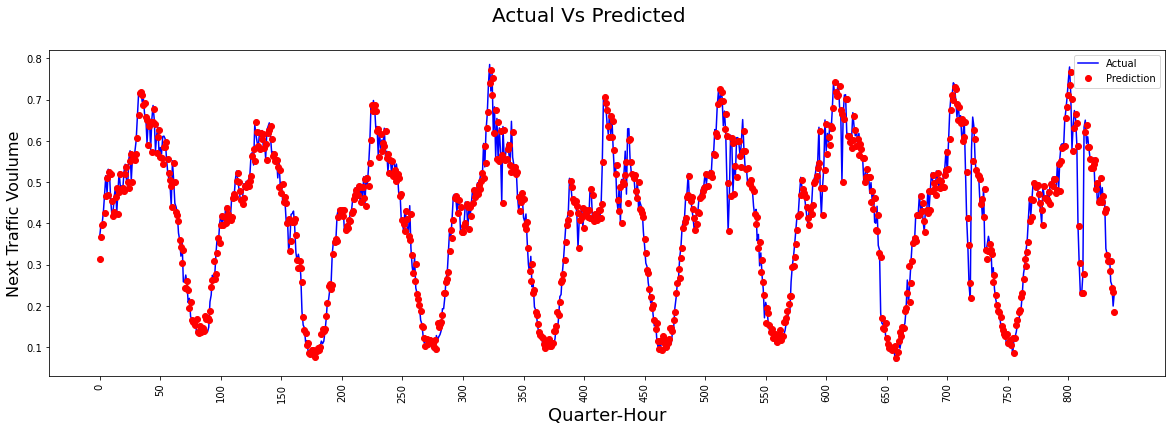

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 23 
Symmetric mean absolute percentage error -> 11.37
Mean absolute percentage error -> 12.17
Root Mean Squared Error -> 0.0005
Mean Absolute Error -> 0.0162
r2_score -> 0.9592
Adjusted r2_score -> 0.9587


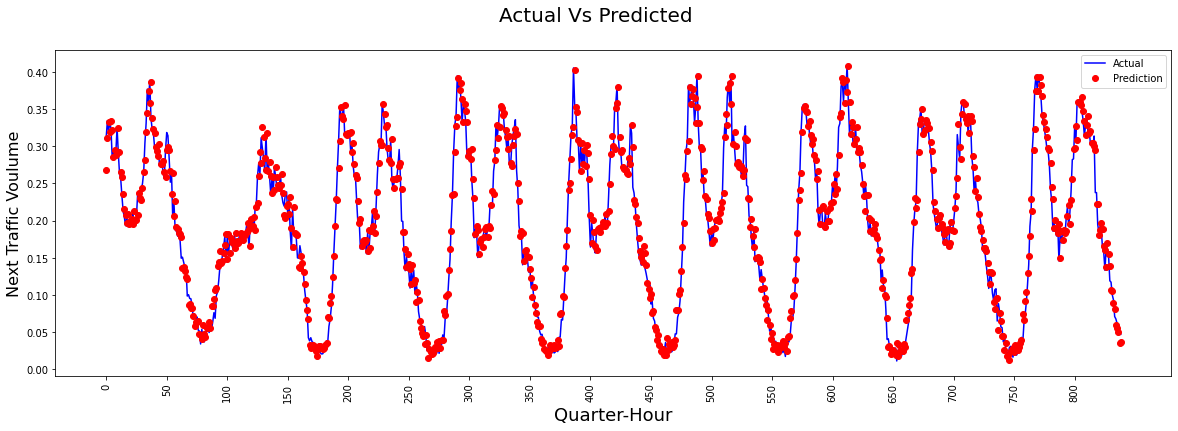

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 24 
Symmetric mean absolute percentage error -> 12.04
Mean absolute percentage error -> 12.9
Root Mean Squared Error -> 0.0004
Mean Absolute Error -> 0.0151
r2_score -> 0.9564
Adjusted r2_score -> 0.9558


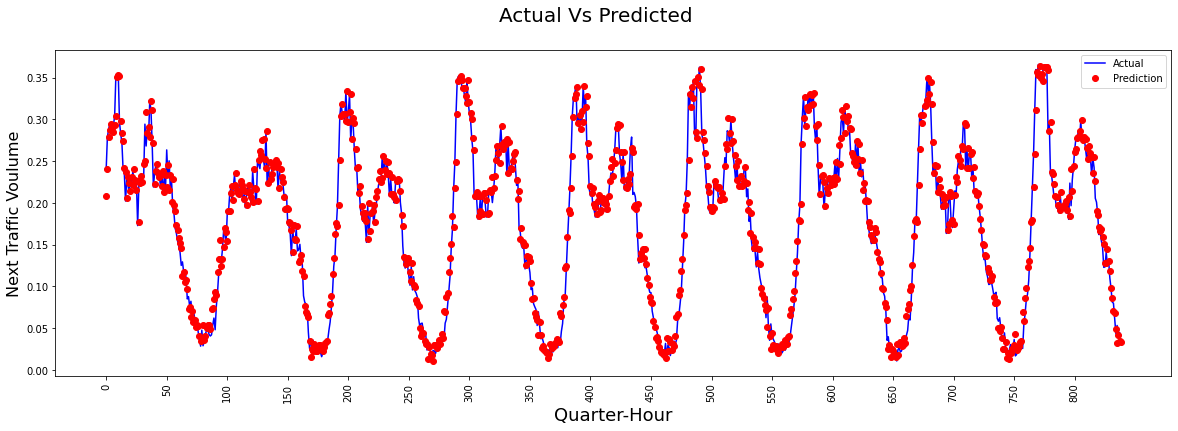

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 25 
Symmetric mean absolute percentage error -> 21.61
Mean absolute percentage error -> 24.55
Root Mean Squared Error -> 0.0003
Mean Absolute Error -> 0.0121
r2_score -> 0.9325
Adjusted r2_score -> 0.9316


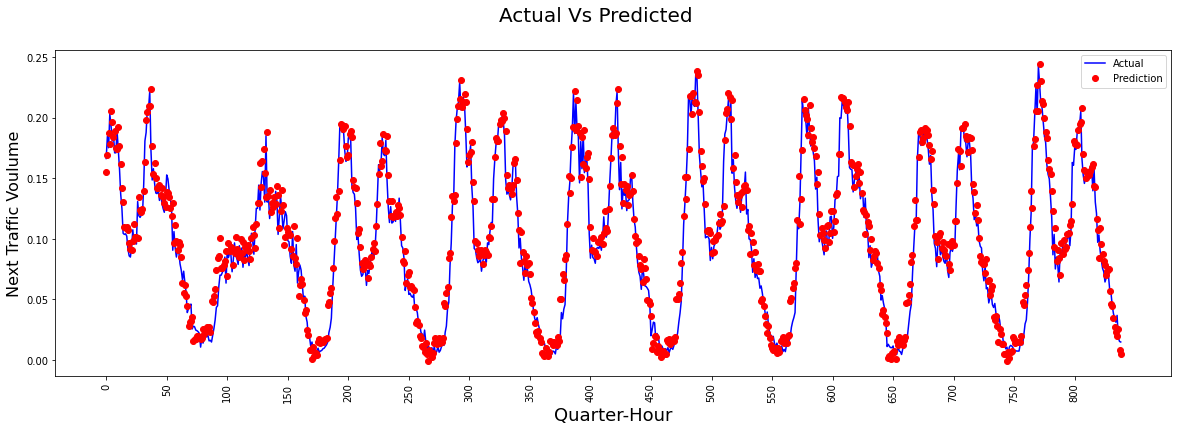

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 26 
Symmetric mean absolute percentage error -> 7.36
Mean absolute percentage error -> 7.43
Root Mean Squared Error -> 0.0017
Mean Absolute Error -> 0.03
r2_score -> 0.9754
Adjusted r2_score -> 0.9751


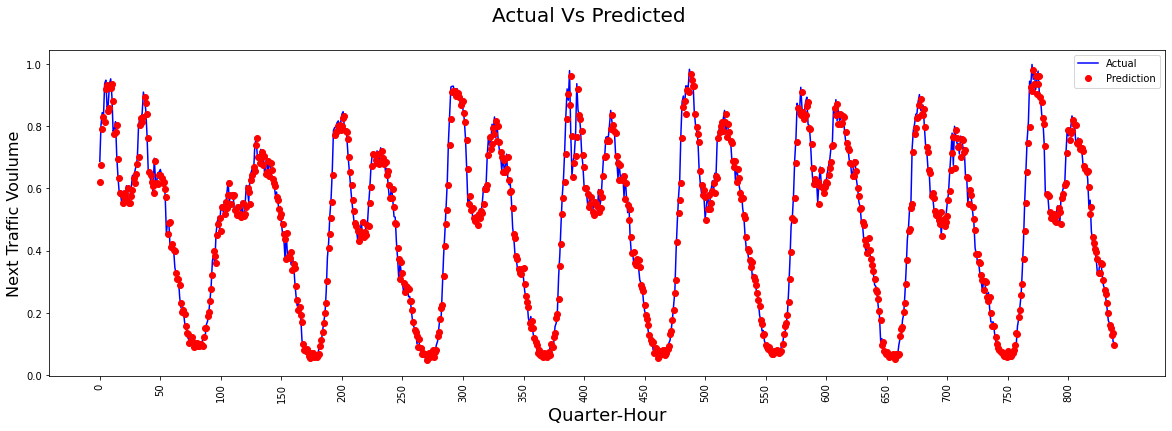

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 27 
Symmetric mean absolute percentage error -> 9.94
Mean absolute percentage error -> 10.61
Root Mean Squared Error -> 0.0007
Mean Absolute Error -> 0.0177
r2_score -> 0.9603
Adjusted r2_score -> 0.9598


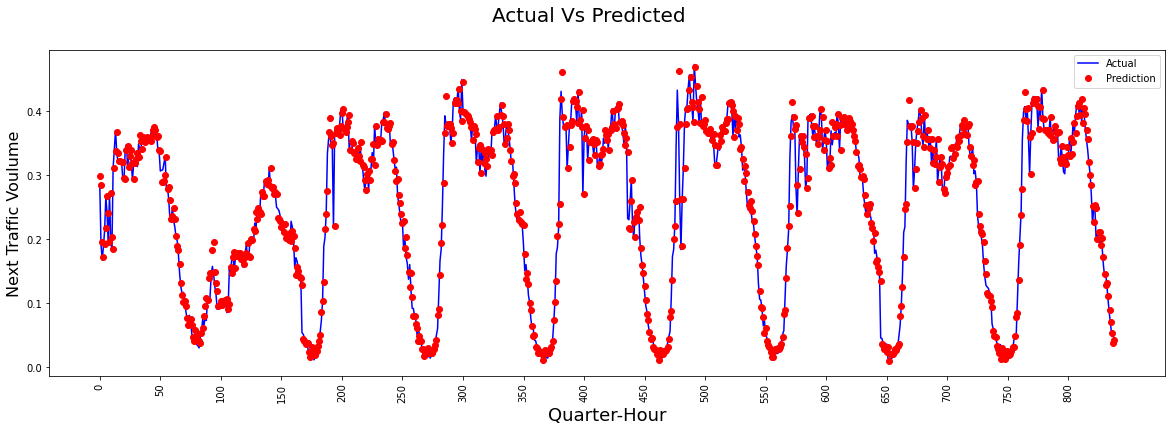

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 28 
Symmetric mean absolute percentage error -> 30.21
Mean absolute percentage error -> 35.96
Root Mean Squared Error -> 0.0045
Mean Absolute Error -> 0.0467
r2_score -> 0.4993
Adjusted r2_score -> 0.4932


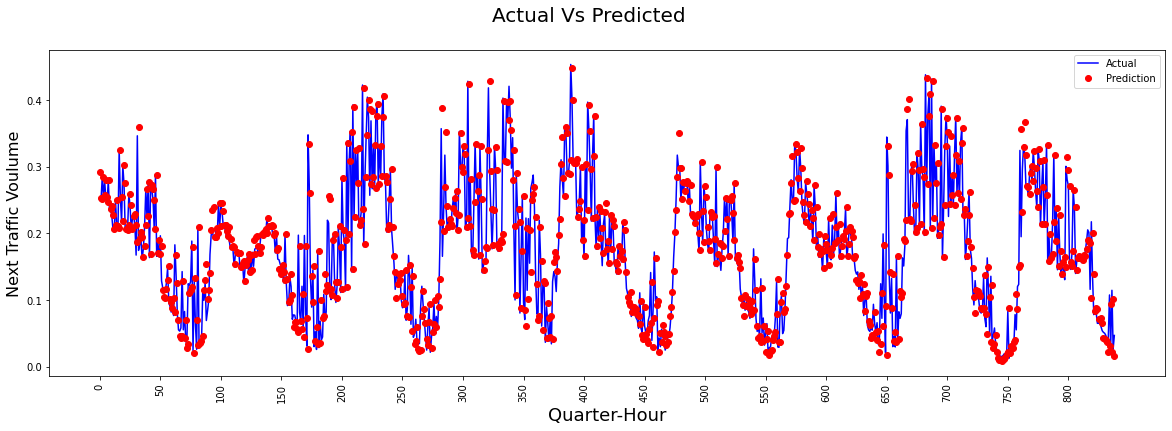

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 29 
Symmetric mean absolute percentage error -> 17.57
Mean absolute percentage error -> 16.8
Root Mean Squared Error -> 0.0004
Mean Absolute Error -> 0.0143
r2_score -> 0.9336
Adjusted r2_score -> 0.9328


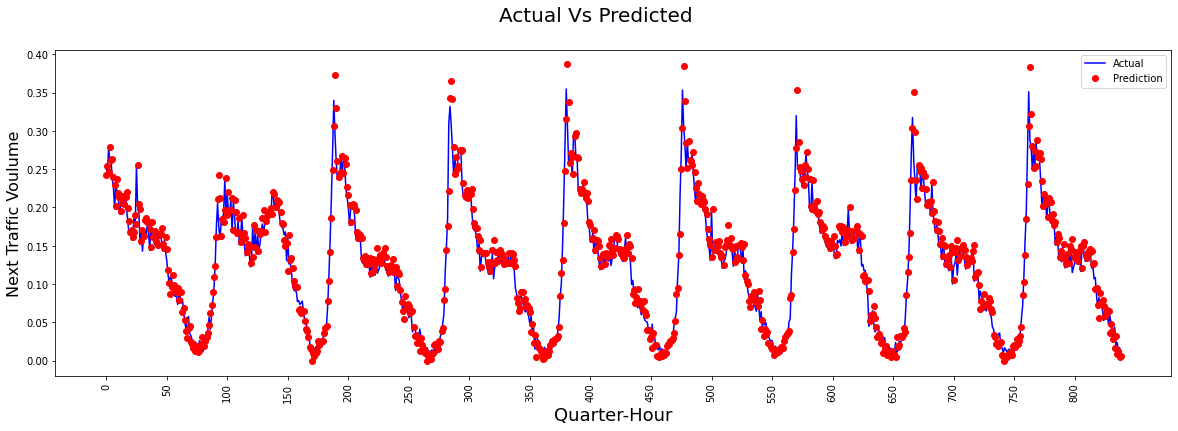

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 30 
Symmetric mean absolute percentage error -> 10.37
Mean absolute percentage error -> 10.31
Root Mean Squared Error -> 0.002
Mean Absolute Error -> 0.0304
r2_score -> 0.9595
Adjusted r2_score -> 0.959


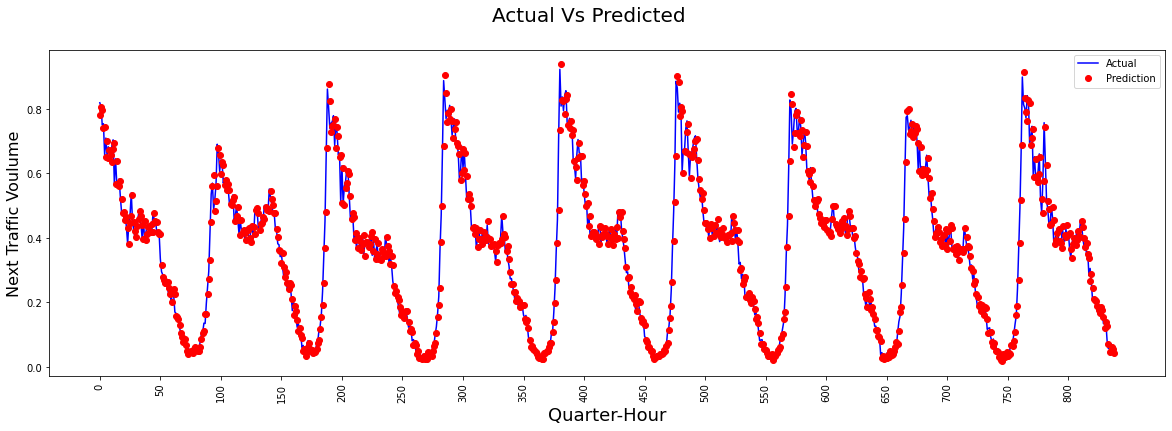

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 31 
Symmetric mean absolute percentage error -> 10.13
Mean absolute percentage error -> 10.82
Root Mean Squared Error -> 0.0015
Mean Absolute Error -> 0.0273
r2_score -> 0.9727
Adjusted r2_score -> 0.9724


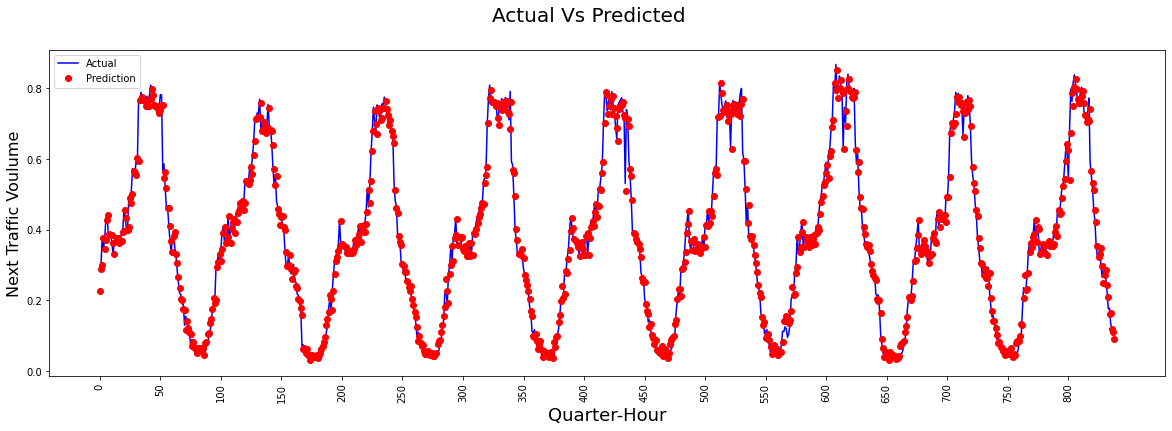

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 32 
Symmetric mean absolute percentage error -> 10.84
Mean absolute percentage error -> 11.68
Root Mean Squared Error -> 0.0016
Mean Absolute Error -> 0.029
r2_score -> 0.9714
Adjusted r2_score -> 0.9711


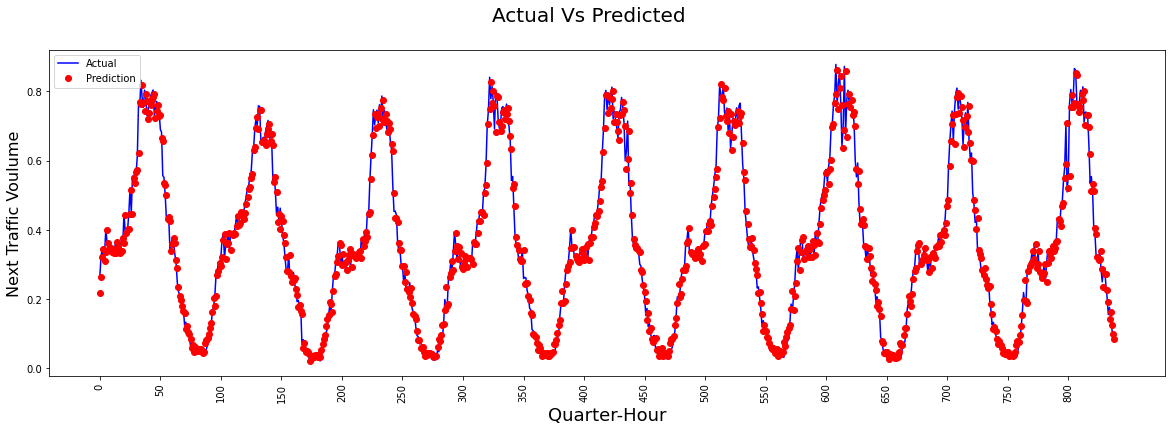

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 33 
Symmetric mean absolute percentage error -> 32.48
Mean absolute percentage error -> 10468965700964.28
Root Mean Squared Error -> 0.0003
Mean Absolute Error -> 0.0142
r2_score -> 0.9578
Adjusted r2_score -> 0.9573


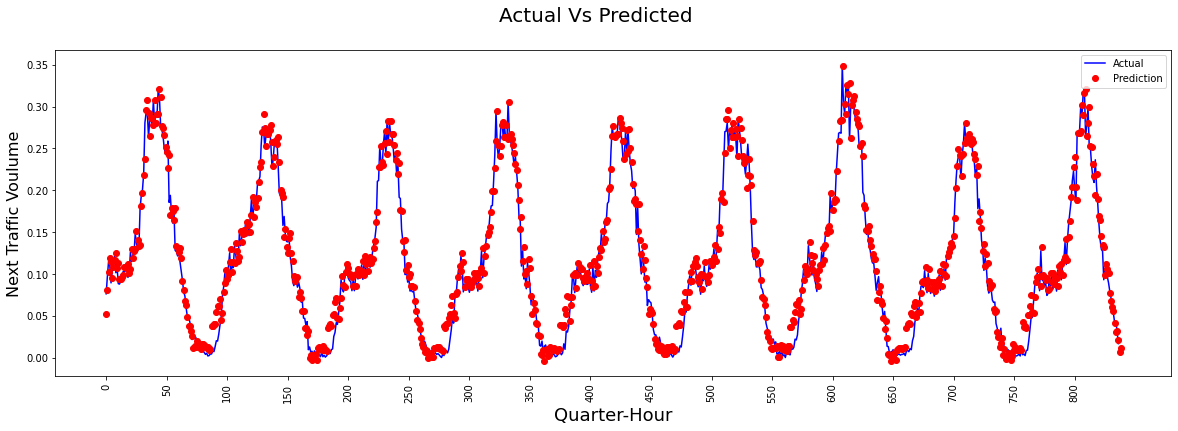

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 34 
Symmetric mean absolute percentage error -> 11.82
Mean absolute percentage error -> 13.26
Root Mean Squared Error -> 0.001
Mean Absolute Error -> 0.0217
r2_score -> 0.9663
Adjusted r2_score -> 0.9659


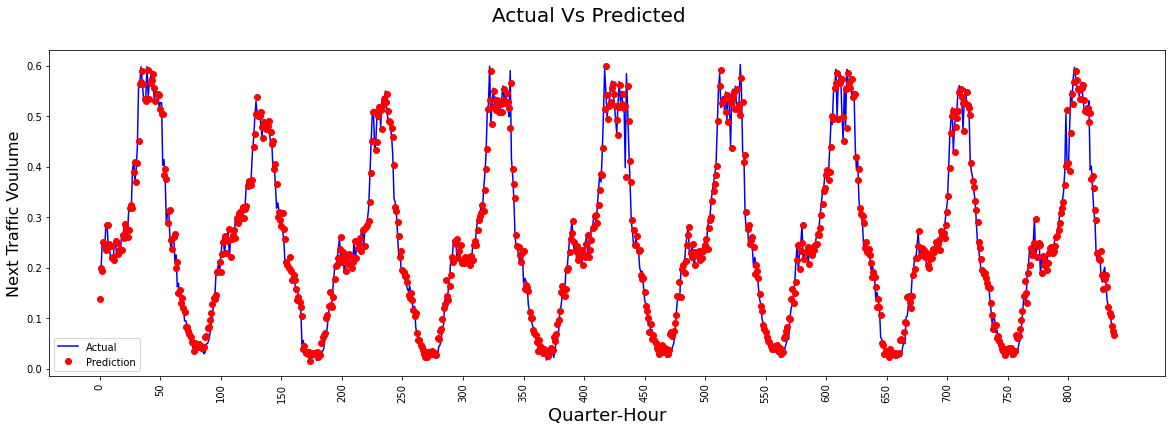

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 35 
Symmetric mean absolute percentage error -> 10.47
Mean absolute percentage error -> 11.38
Root Mean Squared Error -> 0.0016
Mean Absolute Error -> 0.0279
r2_score -> 0.9723
Adjusted r2_score -> 0.972


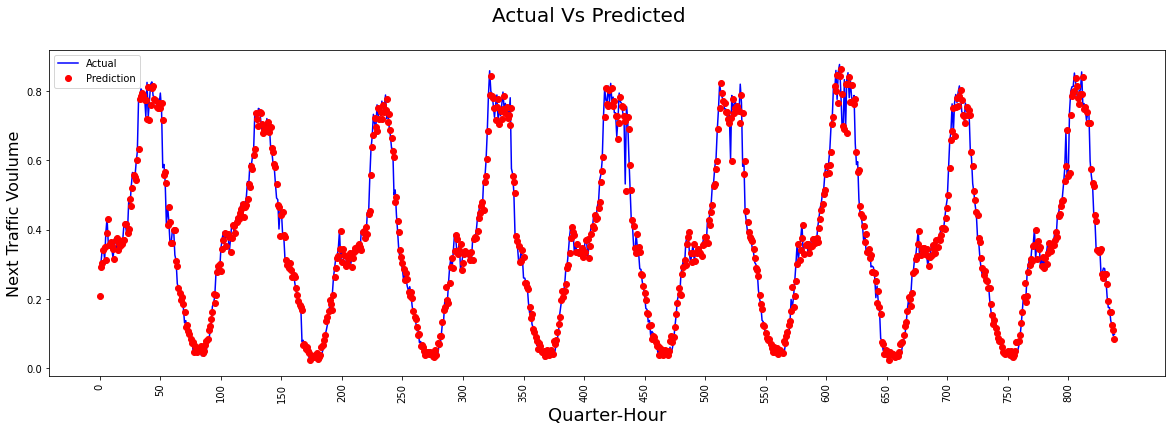

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
For sensor location number -> 36 
Symmetric mean absolute percentage error -> 10.14
Mean absolute percentage error -> 10.06
Root Mean Squared Error -> 0.0021
Mean Absolute Error -> 0.0301
r2_score -> 0.9589
Adjusted r2_score -> 0.9584


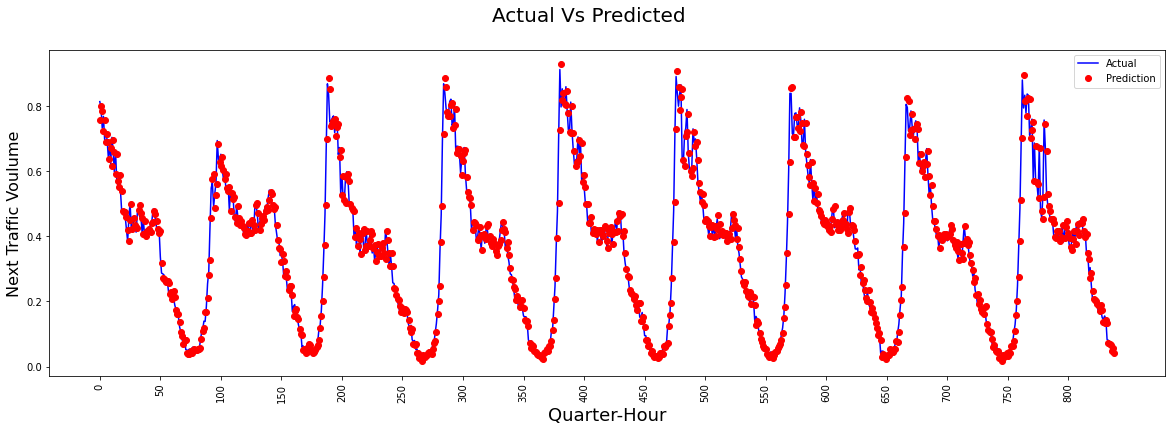

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [30]:
for item in list(set(df_test['spatial_location_number'])):
    data=df_test[df_test['spatial_location_number']==item]
    X = data.drop(['spatial_location_number','next_traffic_flow'], axis=1)
    X=X[imp_features]
    y = data.next_traffic_flow.to_numpy()
    p=pipeline.predict(X)
    print("For sensor location number -> {} ".format(item))
    
    print("Symmetric mean absolute percentage error -> {}".format(round(smape(y, p),2)))
    print("Mean absolute percentage error -> {}".format(round(mean_absolute_percentage_error(y, p)*100,2)))

    #print("Mean Squared Error -> {}".format(round(mean_squared_error(y, p),4)))
    print("Root Mean Squared Error -> {}".format(round(mean_squared_error(y, p),4)))
    print("Mean Absolute Error -> {}".format(round(mean_absolute_error(y, p),4)))
    print("r2_score -> {}".format(round(r2_score(y, p),4)))
    print("Adjusted r2_score -> {}".format(round(1 - ( 1-pipeline.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 ),4)))
    
    plt.figure(figsize=(20,6))
    plt.plot(y, 'b-', label = 'Actual')
    plt.plot(p, 'ro', label = 'Prediction')
    plt.suptitle('Actual Vs Predicted', fontsize=20)
    plt.xlabel('Quarter-Hour', fontsize=18)
    plt.ylabel('Next Traffic Voulume', fontsize=16)
    plt.xticks(np.arange(0, 839+1, 50))

    plt.xticks(rotation = '90')
    plt.legend()
    
    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

**Prediction for all 36 sensor location for quarter hour 840 of test dataset**

In [31]:
data=df_test_future.copy()
X = data.drop(['input_array','spatial_location_number','next_traffic_flow'], axis=1)
X=X[imp_features]
#X=sc.transform(X)
df_test_future['next_traffic_flow']=np.asarray([x if x > 0 else 0 for x in list(pipeline.predict(X))])
Future_Prediction=df_test_future[['quarter-hours','spatial_location_number','traffic_flow','next_traffic_flow']]
Future_Prediction.reset_index(drop=True)

,quarter-hours,spatial_location_number,traffic_flow,next_traffic_flow
0,840,1,0.042036,0.031307
1,840,2,0.072396,0.061083
2,840,3,0.059318,0.048234
3,840,4,0.085007,0.073462
4,840,5,0.143391,0.130717
5,840,6,0.123307,0.110835
6,840,7,0.135451,0.122557
7,840,8,0.083139,0.071627
8,840,9,0.095283,0.083521
9,840,10,0.087342,0.075862
